# Thyroid Cancer Prediction: Decision Tree-Based Clinical Decision Support

This notebook presents an end-to-end machine learning system for predicting thyroid cancer diagnosis (Benign vs Malignant) using interpretable Decision Trees. 

### System Features:
- **Feature Engineering**: Comprehensive use of clinical, demographic, and laboratory data.
- **Data Integrity**: strict separation of training and testing data to ensure unbiased evaluation.
- **Interpretable Decision Tree**: Limited-depth tree (max_depth=3) for clinical interpretability.
- **Danger Zone Extraction**: Data-driven cut-off values and risk thresholds for key clinical attributes.
- **Clinical Prediction Interface**: Modular system for real-world patient risk assessment with interpretable rules.

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

## 1. Data Loading and Preprocessing

In [152]:
# Load dataset
df = pd.read_csv('data/thyroid_cancer_risk_data.csv')

# Encode target variable
df['Diagnosis'] = df['Diagnosis'].map({'Benign': 0, 'Malignant': 1})

df_0 = df[df['Diagnosis'] == 0]  # Benign
df_1 = df[df['Diagnosis'] == 1]  # Malignant

# Determine minority class size
n_samples = min(len(df_0), len(df_1))

# Sample equal number from both classes
df_0_sampled = df_0.sample(n=n_samples, random_state=42)
df_1_sampled = df_1.sample(n=n_samples, random_state=42)

# Combine and shuffle
df_balanced = pd.concat([df_0_sampled, df_1_sampled]) \
                 .sample(frac=1, random_state=42)


X = df_balanced.drop(columns=['Patient_ID', 'Diagnosis'])
y = df_balanced['Diagnosis']

# Check new class distribution
print("Balanced class distribution:")
print(y.value_counts())
print(f"\nMalignant rate: {y.mean():.2%}")

## training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} instances")
print(f"Test set: {X_test.shape[0]} instances")

Balanced class distribution:
Diagnosis
0    49495
1    49495
Name: count, dtype: int64

Malignant rate: 50.00%

Training set: 79192 instances
Test set: 19798 instances


## 2. Feature Preprocessing

Identify numerical and categorical features, then set up preprocessing pipeline.


In [153]:
# Identify feature types
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features ({len(numerical_cols)}): {numerical_cols}")
print(f"\nCategorical features ({len(categorical_cols)}): {categorical_cols}")

# Preprocessing: standardize numerical, one-hot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

Numerical features (5): ['Age', 'TSH_Level', 'T3_Level', 'T4_Level', 'Nodule_Size']

Categorical features (10): ['Gender', 'Country', 'Ethnicity', 'Family_History', 'Radiation_Exposure', 'Iodine_Deficiency', 'Smoking', 'Obesity', 'Diabetes', 'Thyroid_Cancer_Risk']


## 3. Decision Tree Model Training

Using Decision Tree with max_depth=5 for interpretability while maintaining reasonable performance.

In [154]:

# Train decision tree
dt_clf = DecisionTreeClassifier(
    max_depth=5, 
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)

dt_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', dt_clf)
])

dt_pipeline.fit(X_train, y_train)

# Predictions
y_pred = dt_pipeline.predict(X_test)
y_pred_proba = dt_pipeline.predict_proba(X_test)

# Evaluation metrics
results = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'CM': confusion_matrix(y_test, y_pred)
}

print("Model Performance:")
print(f"Accuracy:  {results['Accuracy']:.4f}")
print(f"Precision: {results['Precision']:.4f}")
print(f"Recall:    {results['Recall']:.4f}")
print(f"F1-Score:  {results['F1-Score']:.4f}")

Model Performance:
Accuracy:  0.6962
Precision: 0.8830
Recall:    0.4523
F1-Score:  0.5982


### 3.1 Performance Metrics Visualization

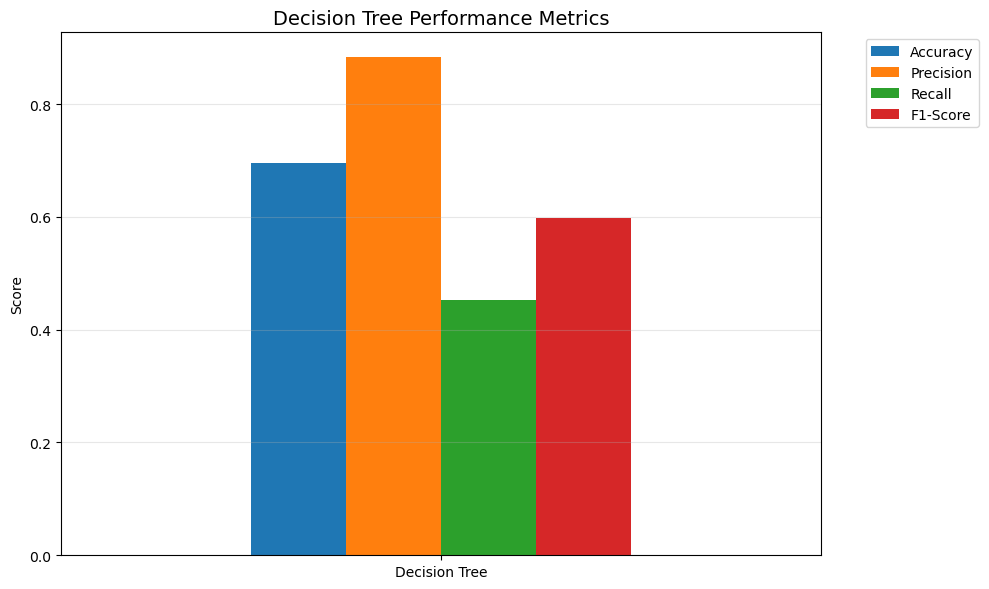

In [155]:
# Plot performance metrics
metrics_dict = {k: v for k, v in results.items() if k != 'CM'}
df_metrics = pd.DataFrame([metrics_dict])
df_metrics.plot(kind='bar', figsize=(10, 6), rot=0)
plt.title('Decision Tree Performance Metrics', fontsize=14)
plt.ylabel('Score')
plt.xticks([0], ['Decision Tree'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

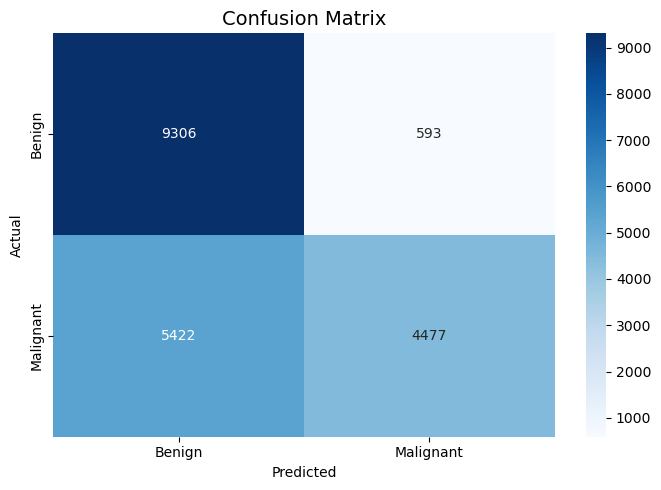

In [156]:
# Confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(results['CM'], annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### 3.2 Decision Tree Structure Visualization


In [157]:
# # Visualize decision tree structure
# tree_classifier = dt_pipeline.named_steps['classifier']
# encoder = dt_pipeline.named_steps['preprocessor'].transformers_[1][1]
# cat_feature_names = list(encoder.get_feature_names_out(categorical_cols))
# all_feature_names = numerical_cols + cat_feature_names

# plt.figure(figsize=(20, 10))
# plot_tree(tree_classifier, filled=True, feature_names=all_feature_names, 
#           class_names=['Benign', 'Malignant'], fontsize=9, max_depth=3)
# plt.title('Decision Tree Structure (showing first 3 levels)', fontsize=14)
# plt.tight_layout()
# plt.show()


## 4. Decision Rule Extraction and Risk Threshold Analysis

Extract decision rules from the trained tree and identify cut-off values for key numerical features. These thresholds are converted back to original clinical units (not scaled values).


In [158]:
def extract_numerical_thresholds(tree, preprocessor, numerical_features):
    """
    Extract decision thresholds for numerical features from the tree.
    Converts scaled thresholds back to original clinical units.
    """
    tree_ = tree.tree_
    thresholds_dict = {}
    scaler = preprocessor.transformers_[0][1]  #

    # Extract thresholds from all non-leaf nodes
    for node in range(tree_.node_count):
        feature_idx = tree_.feature[node]
        thresh = tree_.threshold[node]

        if feature_idx == -2:  # Skip leaf nodes
            continue

        # Process numerical features only
        if feature_idx < len(numerical_features):
            feature_name = numerical_features[feature_idx]
            # Inverse transform: convert from scaled to original units
            original_thresh = thresh * scaler.scale_[feature_idx] + scaler.mean_[feature_idx]
            thresholds_dict.setdefault(feature_name, []).append(original_thresh)

    # Sort and deduplicate
    for feature in thresholds_dict:
        thresholds_dict[feature] = sorted(set(thresholds_dict[feature]))

    return thresholds_dict

In [159]:
def define_danger_zones(thresholds_dict, X_train_original):
    """
    Define risk zones (low, moderate, high) based on extracted thresholds.
    Creates interpretable ranges for clinical decision-making.
    """
    danger_zones = {}
    
    for feature, thresh_values in thresholds_dict.items():
        if not thresh_values:
            continue

        sorted_thresh = sorted(set(thresh_values))
        feature_data = X_train_original[feature]
        min_val, max_val = feature_data.min(), feature_data.max()
        zones = []

        # Create zones based on number of thresholds
        if len(sorted_thresh) == 1:
            zones = [
                {'zone': 'Low Risk', 'range': f"< {sorted_thresh[0]:.2f}"},
                {'zone': 'High Risk', 'range': f">= {sorted_thresh[0]:.2f}"}
            ]
        elif len(sorted_thresh) == 2:
            zones = [
                {'zone': 'Low Risk', 'range': f"< {sorted_thresh[0]:.2f}"},
                {'zone': 'Moderate Risk', 'range': f"{sorted_thresh[0]:.2f} - {sorted_thresh[1]:.2f}"},
                {'zone': 'High Risk', 'range': f">= {sorted_thresh[1]:.2f}"}
            ]
        else:
            # Multiple thresholds - create zones between them
            for i, t in enumerate(sorted_thresh):
                if i == 0:
                    zones.append({'zone': 'Low Risk', 'range': f"< {t:.2f}"})
                if i < len(sorted_thresh) - 1:
                    zones.append({'zone': 'Moderate Risk', 'range': f"{t:.2f} - {sorted_thresh[i+1]:.2f}"})
                if i == len(sorted_thresh) - 1:
                    zones.append({'zone': 'High Risk', 'range': f">= {t:.2f}"})

        danger_zones[feature] = {
            'thresholds': sorted_thresh,
            'zones': zones,
            'min': min_val,
            'max': max_val
        }

    return danger_zones

# Extract thresholds from trained tree
preprocessor_obj = dt_pipeline.named_steps['preprocessor']
tree_model = dt_pipeline.named_steps['classifier']
thresholds = extract_numerical_thresholds(tree_model, preprocessor_obj, numerical_cols)

# Define danger zones
X_train_original = X_train.copy()
danger_zones = define_danger_zones(thresholds, X_train_original)

# Display results
print("\n" + "=" * 70)
print("EXTRACTED RISK THRESHOLDS (Original Clinical Units)")
print("=" * 70)

for feature, info in danger_zones.items():
    print(f"\n{feature}:")
    print(f"  Data range: {info['min']:.2f} to {info['max']:.2f}")
    print(f"  Key thresholds: {[round(t, 2) for t in info['thresholds'][:5]]}..." if len(info['thresholds']) > 5 
          else f"  Key thresholds: {[round(t, 2) for t in info['thresholds']]}")
    print(f"  Risk zones: {len(info['zones'])} zones defined")


EXTRACTED RISK THRESHOLDS (Original Clinical Units)

TSH_Level:
  Data range: 0.10 to 10.00
  Key thresholds: [np.float64(0.48), np.float64(0.96), np.float64(1.91), np.float64(7.54), np.float64(9.97)]
  Risk zones: 6 zones defined

T4_Level:
  Data range: 4.50 to 12.00
  Key thresholds: [np.float64(4.51), np.float64(4.63), np.float64(8.65), np.float64(9.36), np.float64(10.94)]...
  Risk zones: 8 zones defined

Nodule_Size:
  Data range: 0.00 to 5.00
  Key thresholds: [np.float64(0.27), np.float64(1.34), np.float64(3.73), np.float64(3.92)]
  Risk zones: 5 zones defined

T3_Level:
  Data range: 0.50 to 3.50
  Key thresholds: [np.float64(0.54), np.float64(0.79), np.float64(0.92), np.float64(3.37)]
  Risk zones: 5 zones defined

Age:
  Data range: 15.00 to 89.00
  Key thresholds: [np.float64(55.5), np.float64(81.5)]
  Risk zones: 3 zones defined


### 4.1 Key Feature Threshold Analysis

Focus on the most clinically relevant features: TSH_Level, Nodule_Size, T3_Level, T4_Level, and Age.


In [160]:
# Focus on key clinical features
key_features = ['TSH_Level', 'Nodule_Size', 'T3_Level', 'T4_Level', 'Age']

print("=" * 70)
print("CLINICAL RISK THRESHOLDS - KEY FEATURES")
print("=" * 70)

for feature in key_features:
    if feature in danger_zones:
        info = danger_zones[feature]
        print(f"\n{feature}:")
        print(f"  Range in data: {info['min']:.2f} to {info['max']:.2f}")
        
        # Show most important thresholds (first and last few)
        thresh_list = info['thresholds']
        if len(thresh_list) <= 3:
            print(f"  Thresholds: {[round(t, 2) for t in thresh_list]}")
        else:
            print(f"  Thresholds: {[round(t, 2) for t in thresh_list[:3]]} ... {[round(t, 2) for t in thresh_list[-3:]]}")
            print(f"  (Total: {len(thresh_list)} thresholds)")
        
        # Show simplified risk zones
        if len(info['zones']) <= 3:
            for zone in info['zones']:
                print(f"    {zone['zone']}: {zone['range']}")
        else:
            print(f"    {info['zones'][0]['zone']}: {info['zones'][0]['range']}")
            print(f"    ... ({len(info['zones'])-2} moderate zones) ...")
            print(f"    {info['zones'][-1]['zone']}: {info['zones'][-1]['range']}")


CLINICAL RISK THRESHOLDS - KEY FEATURES

TSH_Level:
  Range in data: 0.10 to 10.00
  Thresholds: [np.float64(0.48), np.float64(0.96), np.float64(1.91)] ... [np.float64(1.91), np.float64(7.54), np.float64(9.97)]
  (Total: 5 thresholds)
    Low Risk: < 0.48
    ... (4 moderate zones) ...
    High Risk: >= 9.97

Nodule_Size:
  Range in data: 0.00 to 5.00
  Thresholds: [np.float64(0.27), np.float64(1.34), np.float64(3.73)] ... [np.float64(1.34), np.float64(3.73), np.float64(3.92)]
  (Total: 4 thresholds)
    Low Risk: < 0.27
    ... (3 moderate zones) ...
    High Risk: >= 3.92

T3_Level:
  Range in data: 0.50 to 3.50
  Thresholds: [np.float64(0.54), np.float64(0.79), np.float64(0.92)] ... [np.float64(0.79), np.float64(0.92), np.float64(3.37)]
  (Total: 4 thresholds)
    Low Risk: < 0.54
    ... (3 moderate zones) ...
    High Risk: >= 3.37

T4_Level:
  Range in data: 4.50 to 12.00
  Thresholds: [np.float64(4.51), np.float64(4.63), np.float64(8.65)] ... [np.float64(10.94), np.float64(11.71

In [161]:
# === 5.1 Feature set and preprocessing for phenotype discovery ===

phenotype_features = [
    'Age', 'Gender', 'TSH_Level', 'T3_Level', 'T4_Level',
    'Nodule_Size', 'Iodine_Deficiency', 'Radiation_Exposure', 'Family_History', 'Thyroid_Cancer_Risk'
]

X_pheno = df[phenotype_features].copy()

# Separate numerical and categorical features
pheno_num_features = ['Age', 'TSH_Level', 'T3_Level', 'T4_Level', 'Nodule_Size']
pheno_cat_features = ['Gender', 'Iodine_Deficiency', 'Radiation_Exposure', 'Family_History', 'Thyroid_Cancer_Risk']

# ColumnTransformer: StandardScaler for numeric, OneHotEncoder for categoricals
phenotype_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), pheno_num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), pheno_cat_features)
    ]
)

# Fit preprocessor and transform data
X_pheno_proc = phenotype_preprocessor.fit_transform(X_pheno)

# === 5.2 K-Means clustering (k = 6) ===

kmeans_phenotypes = KMeans(n_clusters=6, random_state=42, n_init=10)
pheno_labels = kmeans_phenotypes.fit_predict(X_pheno_proc)

# Attach phenotype label back to original dataframe (no Diagnosis used in training)
df['Patient_Phenotype'] = pheno_labels

print("Assigned Patient_Phenotype (0-5) to all patients.")


Assigned Patient_Phenotype (0-5) to all patients.


In [162]:
# === 5.3 Phenotype summary table ===

# Helper to get most frequent category (mode) safely
def most_frequent(series):
    mode_vals = series.mode()
    return mode_vals.iloc[0] if not mode_vals.empty else np.nan

pheno_summary = df.groupby('Patient_Phenotype').agg({
    'Age': 'mean',
    'TSH_Level': 'mean',
    'T3_Level': 'mean',
    'T4_Level': 'mean',
    'Nodule_Size': 'mean',
    'Gender': most_frequent,
    'Iodine_Deficiency': most_frequent,
    'Radiation_Exposure': most_frequent,
    'Family_History': most_frequent,
    'Thyroid_Cancer_Risk': most_frequent
})

print("Phenotype summary (means for numerical, most frequent for categorical):")
pheno_summary.round(2)


Phenotype summary (means for numerical, most frequent for categorical):


,Age,TSH_Level,T3_Level,T4_Level,Nodule_Size,Gender,Iodine_Deficiency,Radiation_Exposure,Family_History,Thyroid_Cancer_Risk
Patient_Phenotype,,,,,,,,,,
0,33.74,5.00,2.58,7.30,1.26,Female,No,No,No,Low
1,69.89,2.66,1.89,6.48,2.53,Female,No,No,No,Low
2,39.67,2.84,2.15,9.74,3.68,Female,No,No,No,Low
3,43.17,7.34,1.42,6.90,3.48,Female,No,No,No,Low
4,68.69,7.20,2.74,9.07,2.73,Female,No,No,No,Low
5,56.02,5.28,1.24,9.95,1.37,Female,No,No,No,Low


In [163]:
# === 5.4 Clinical interpretation and new-patient assignment ===

# Overall means to compare each phenotype against the cohort
overall_means = df[pheno_num_features].mean()

print("\nClinical interpretation of Patient_Phenotype groups:")
for pheno_id, row in pheno_summary.iterrows():
    desc_parts = []
    
    # Age profile
    if row['Age'] > overall_means['Age']:
        desc_parts.append('older-than-average age')
    else:
        desc_parts.append('younger-than-average age')
    
    # Hormone profiles
    if row['TSH_Level'] > overall_means['TSH_Level']:
        desc_parts.append('higher TSH')
    else:
        desc_parts.append('lower TSH')

    if row['T3_Level'] > overall_means['T3_Level']:
        desc_parts.append('higher T3')
    else:
        desc_parts.append('lower T3')

    if row['T4_Level'] > overall_means['T4_Level']:
        desc_parts.append('higher T4')
    else:
        desc_parts.append('lower T4')

    # Nodule size
    if row['Nodule_Size'] > overall_means['Nodule_Size']:
        desc_parts.append('larger thyroid nodules')
    else:
        desc_parts.append('smaller thyroid nodules')

    # Iodine status and family history
    iodine_mode = row['Iodine_Deficiency']
    fam_hist_mode = row['Family_History']
    radiation_mode = row['Radiation_Exposure']
    risk_cat_mode = row['Thyroid_Cancer_Risk']

    print(f"\nPatient_Phenotype {pheno_id}:")
    print(f"  Summary: {', '.join(desc_parts)}; typical risk category: {risk_cat_mode}")
    print(f"  Most common gender: {row['Gender']}")
    print(f"  Iodine deficiency (mode): {iodine_mode}")
    print(f"  Radiation Exposure (mode): {radiation_mode}")
    print(f"  Family history of thyroid disease/cancer (mode): {fam_hist_mode}")


def classify_patient_phenotype(patient_data):
    """Assign a Patient_Phenotype to a new patient using the K-Means model.

    The function applies the same preprocessing pipeline (StandardScaler + OneHotEncoder)
    that was used during training, ensuring consistency between training and inference.
    """
    patient_df = pd.DataFrame([patient_data])
    patient_df = patient_df[phenotype_features]

    X_new = phenotype_preprocessor.transform(patient_df)
    pheno_id = kmeans_phenotypes.predict(X_new)[0]
    return int(pheno_id)





Clinical interpretation of Patient_Phenotype groups:

Patient_Phenotype 0:
  Summary: younger-than-average age, lower TSH, higher T3, lower T4, smaller thyroid nodules; typical risk category: Low
  Most common gender: Female
  Iodine deficiency (mode): No
  Radiation Exposure (mode): No
  Family history of thyroid disease/cancer (mode): No

Patient_Phenotype 1:
  Summary: older-than-average age, lower TSH, lower T3, lower T4, larger thyroid nodules; typical risk category: Low
  Most common gender: Female
  Iodine deficiency (mode): No
  Radiation Exposure (mode): No
  Family history of thyroid disease/cancer (mode): No

Patient_Phenotype 2:
  Summary: younger-than-average age, lower TSH, higher T3, higher T4, larger thyroid nodules; typical risk category: Low
  Most common gender: Female
  Iodine deficiency (mode): No
  Radiation Exposure (mode): No
  Family history of thyroid disease/cancer (mode): No

Patient_Phenotype 3:
  Summary: younger-than-average age, higher TSH, lower T3, lo

### 6 Predict Patient

In [164]:
def predict_new_patient(patient_data, danger_zones=None):
    """
    Predict diagnosis, assign a phenotype profile, and assess risk zones for a new patient.
    
    Returns: (diagnosis, confidence, risk_assessment, patient_phenotype)
    """
    patient_df = pd.DataFrame([patient_data])
    patient_df = patient_df[X.columns]
    
    # 1) Supervised diagnosis prediction (Decision Tree)
    pred_class = dt_pipeline.predict(patient_df)[0]
    pred_prob = dt_pipeline.predict_proba(patient_df)[0][pred_class]
    
    result = "Malignant" if pred_class == 1 else "Benign"
    confidence = pred_prob
    
    # 2) Unsupervised phenotype assignment (K-Means-based profile)
    try:
        patient_phenotype = classify_patient_phenotype(patient_data)

        # Print descriptive phenotype info
        if patient_phenotype is not None and 'pheno_summary' in globals() and 'overall_means' in globals():
            row = pheno_summary.loc[patient_phenotype]
            desc_parts = []
            
            # Age profile
            if row['Age'] > overall_means['Age']:
                desc_parts.append('older-than-average age')
            else:
                desc_parts.append('younger-than-average age')
            
            # Hormone profiles
            if row['TSH_Level'] > overall_means['TSH_Level']:
                desc_parts.append('higher TSH')
            else:
                desc_parts.append('lower TSH')

            if row['T3_Level'] > overall_means['T3_Level']:
                desc_parts.append('higher T3')
            else:
                desc_parts.append('lower T3')

            if row['T4_Level'] > overall_means['T4_Level']:
                desc_parts.append('higher T4')
            else:
                desc_parts.append('lower T4')

            # Nodule size
            if row['Nodule_Size'] > overall_means['Nodule_Size']:
                desc_parts.append('larger thyroid nodules')
            else:
                desc_parts.append('smaller thyroid nodules')

            risk_cat_mode = row['Thyroid_Cancer_Risk']
            
            print(f"\nAssigned Patient_Phenotype {patient_phenotype}:")
            print(f"  Summary: {', '.join(desc_parts)}; typical risk category: {risk_cat_mode}")
            print(f"  Most common gender: {row['Gender']}")
            print(f"  Iodine deficiency (mode): {row['Iodine_Deficiency']}")
            print(f"  Radiation Exposure (mode): {row['Radiation_Exposure']}")
            print(f"  Family history of thyroid disease/cancer (mode): {row['Family_History']}")
    except Exception as e:
        # If phenotype model not yet fitted / cells not run, return None and warn
        print(f"[Warning] Phenotype model not initialized or error: {str(e)}")
        patient_phenotype = None
    
    # 3) Risk zone assessment for key features
    risk_assessment = {}
    if danger_zones:
        for feature_name, zone_info in danger_zones.items():
            if feature_name in patient_data:
                value = patient_data[feature_name]
                thresholds = zone_info['thresholds']
                
                # Determine risk zone
                if len(thresholds) == 1:
                    zone = 'Low Risk' if value < thresholds[0] else 'High Risk'
                elif len(thresholds) >= 2:
                    if value < thresholds[0]:
                        zone = 'Low Risk'
                    elif value >= thresholds[-1]:
                        zone = 'High Risk'
                    else:
                        zone = 'Moderate Risk'
                else:
                    zone = 'Unknown'
                
                risk_assessment[feature_name] = {
                    'value': value,
                    'zone': zone,
                    'thresholds': thresholds
                }
    
    return result, confidence, risk_assessment, patient_phenotype


In [165]:
# Example patient case
sample_patient = {
    'Age': 45, 'Gender': 'Female', 'Country': 'Canada', 'Ethnicity': 'Caucasian',
    'Family_History': 'No', 'Radiation_Exposure': 'No', 'Iodine_Deficiency': 'No',
    'Smoking': 'No', 'Obesity': 'No', 'Diabetes': 'No', 
    'TSH_Level': 1.8, 'T3_Level': 2.1, 'T4_Level': 11.5, 
    'Nodule_Size': 3.2, 'Thyroid_Cancer_Risk': 'High'
}

# Make prediction (diagnosis + risk zones + phenotype)
diagnosis, confidence, risk_assessment, patient_phenotype = predict_new_patient(sample_patient, danger_zones=danger_zones)

print("=" * 70)
print("EXAMPLE PREDICTION")
print("=" * 70)

print("\nPatient Features:")
for key in ['Age', 'TSH_Level', 'T3_Level', 'T4_Level', 'Nodule_Size']:
    print(f"  {key}: {sample_patient[key]}")

print(f"\nPrediction:")
print(f"  Diagnosis: {diagnosis}")
print(f"  Confidence: {confidence:.2%}")
print(f"  Assigned Patient_Phenotype: {patient_phenotype}")

print(f"\nRisk Zone Assessment:")
for feature_name, assessment in risk_assessment.items():
    if feature_name in key_features:
        print(f"  {feature_name}: {assessment['value']} → {assessment['zone']}")


Assigned Patient_Phenotype 2:
  Summary: younger-than-average age, lower TSH, higher T3, higher T4, larger thyroid nodules; typical risk category: Low
  Most common gender: Female
  Iodine deficiency (mode): No
  Radiation Exposure (mode): No
  Family history of thyroid disease/cancer (mode): No
EXAMPLE PREDICTION

Patient Features:
  Age: 45
  TSH_Level: 1.8
  T3_Level: 2.1
  T4_Level: 11.5
  Nodule_Size: 3.2

Prediction:
  Diagnosis: Malignant
  Confidence: 88.42%
  Assigned Patient_Phenotype: 2

Risk Zone Assessment:
  TSH_Level: 1.8 → Moderate Risk
  T4_Level: 11.5 → Moderate Risk
  Nodule_Size: 3.2 → Moderate Risk
  T3_Level: 2.1 → Moderate Risk
  Age: 45 → Low Risk
